In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:
bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/rotation/25h9/s_yaw_25h9_5m_720_30.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,19.184147
1,0.314762,9.728676
2,0.646649,2.299237
3,1.004957,4.661084
4,1.367453,5.171209
...,...,...
634,73.828207,56.307009
635,73.936139,56.278071
636,74.036772,56.514312
637,74.148811,57.617451


<AxesSubplot:xlabel='relative_time'>

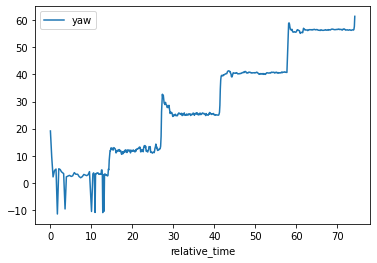

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
df_filtered_by_targets = df

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

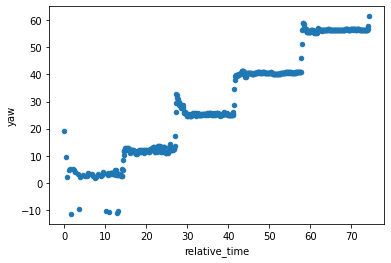

In [7]:
df.plot.scatter(x='relative_time', y=target)

In [8]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets['relative_time'], bins=[1,15,27,41,57,75], labels=input_vals)

In [9]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [10]:
# remove huge errors because theyre actually wrongly binned
df_filtered_by_targets = df_filtered_by_targets.drop(df_filtered_by_targets[df_filtered_by_targets['error'].abs()>11].index)

In [11]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [12]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.tail(2)

,relative_time,yaw,true_yaw,error
62,14.347066,8.461852,0,-8.461852
63,14.448272,10.386740,0,-10.386740
182,26.780466,12.708142,15,2.291858
183,26.888347,13.603502,15,1.396498
317,40.816967,24.987991,30,5.012009
318,40.928252,24.972274,30,5.027726
470,56.845965,40.769670,45,4.230330
471,56.949618,40.801504,45,4.198496
637,74.148811,57.617451,60,2.382549
638,74.250611,61.320791,60,-1.320791


In [13]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,60.0,-2.507749,4.132302,-10.386740,-3.744237,-3.281333,-2.849273,10.834382
15,115.0,2.843838,0.744830,0.641127,2.403053,2.949946,3.428508,4.399770
30,134.0,4.117828,1.517798,-2.687133,4.272965,4.609020,4.850634,5.494382
45,149.0,4.605615,0.641585,3.714726,4.345477,4.482466,4.754018,10.326171
60,159.0,3.668043,0.746704,-1.320791,3.522540,3.648359,3.768468,8.823672


In [14]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

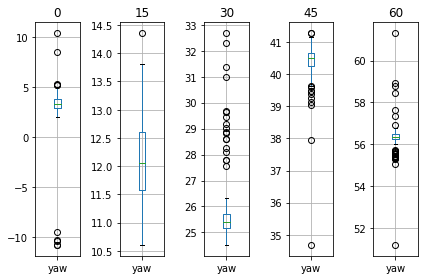

In [15]:
box_plotter(target)

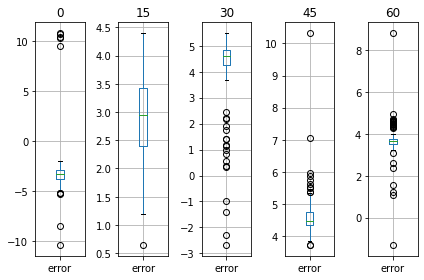

In [16]:
box_plotter('error')

In [17]:
df_filtered_by_targets.to_csv('/home/hakanergin/code/apriltag_test_bench/test_pipeline/scripts/static_tests/rotations/result/csv/5m_25h9_720.csv')